In [99]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from model_v2 import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
import pandas as pd
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A
import warnings
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import seaborn as sns

In [81]:
columns = [
    'epoch', 'train loss', 'valid loss', 'train_dice', 'train_l_dice', 'train_bal_acc',
    'train_l_bal_acc', 'val_dice', 'val_l_dice', 'val_l_bal_acc', 'val_bal_acc'
]

m1 = pd.read_csv('model_results1.txt', names=columns)
m2 = pd.read_csv('model_results2.txt', names=columns)
m3 = pd.read_excel('./model_results_off.xlsx')
m4 = pd.read_csv('model_results4.txt', names=columns)

In [82]:
m1['val_dice'] = m1['val_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['train_dice'] = m1['train_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['val_l_dice'] = m1['val_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['train_l_dice'] = m1['train_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)

m2['val_dice'] = m2['val_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['train_dice'] = m2['train_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['val_l_dice'] = m2['val_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['train_l_dice'] = m2['train_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)

m3['train_dice'] = pd.to_numeric(m3['train_dice'])
m3['val_dice'] = pd.to_numeric(m3['val_dice'])

m4['val_dice'] = m4['val_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['train_dice'] = m4['train_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['val_l_dice'] = m4['val_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['train_l_dice'] = m4['train_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)


In [85]:
m4

epoch  train loss  valid loss  train_dice  train_l_dice  train_bal_acc  \
0       0    1.563911    1.523631      0.2573        0.0051       0.564626   
1       1    1.583257    1.477153      0.2338        0.0047       0.554790   
2       2    1.550895    1.519008      0.2695        0.0048       0.560607   
3       3    1.549327    1.529816      0.2656        0.0049       0.555047   
4       4    1.567222    1.516551      0.2501        0.0052       0.541264   
5       5    1.565915    1.493119      0.2515        0.0050       0.536573   
6       6    1.524903    1.511674      0.2890        0.0054       0.546821   
7       7    1.550101    1.533966      0.2695        0.0060       0.546668   
8       8    1.564425    1.536746      0.2559        0.0050       0.558634   
9       9    1.579754    1.518621      0.2405        0.0050       0.554156   
10     10    1.528867    1.502238      0.2802        0.0047       0.544217   
11     11    1.542575    1.526904      0.2779        0.0048       0.563129   
12     12    1.556833    1.499051      0.2569        0.0051       0.539373   
13     13    1.547436    1.508787      0.2737        0.0056       0.555368   
14     14    1.551522    1.525927      0.2617        0.0053       0.550244   
15     15    1.563651    1.520136      0.2582        0.0050       0.559015   
16     16    1.544407    1.538177      0.2691        0.0046       0.554897   
17     17    1.574366    1.525545      0.2402        0.0047       0.551424   
18     18    1.569960    1.498472      0.2381        0.0064       0.529233   
19     19    1.581856    1.530629      0.2300        0.0043       0.541586   
20     20    1.573720    1.551103      0.2431        0.0046       0.547852   
21     21    1.568927    1.518601      0.2516        0.0048       0.548420   
22     22    1.561148    1.545972      0.2509        0.0047       0.546570   
23     23    1.562614    1.501151      0.2506        0.0051       0.542298   
24     24    1.554460    1.525457      0.2614        0.0053       0.546404   
25     25    1.570272    1.538711      0.2496        0.0042       0.555871   
26     26    1.552181    1.564582      0.2685        0.0047       0.558635   
27     27    1.543832    1.562016      0.2695        0.0051       0.545630   
28     28    1.551968    1.495888      0.2653        0.0048       0.553970   
29     29    1.543724    1.542199      0.2684        0.0053       0.548449   
30     30    1.603265    1.543099      0.2124        0.0044       0.552028   
31     31    1.575217    1.542788      0.2424        0.0050       0.554892   
32     32    1.579642    1.546840      0.2416        0.0043       0.567032   
33     33    1.537388    1.521807      0.2749        0.0043       0.548798   
34     34    1.564093    1.566176      0.2542        0.0055       0.551898   
35     35    1.596211    1.544612      0.2207        0.0052       0.540308   
36     36    1.569839    1.547869      0.2454        0.0047       0.555234   
37     37    1.550990    1.570808      0.2627        0.0055       0.548626   
38     38    1.571792    1.543120      0.2455        0.0047       0.554978   
39     39    1.572910    1.508160      0.2423        0.0041       0.563178   
40     40    1.551323    1.524905      0.2630        0.0043       0.556918   
41     41    1.535179    1.547429      0.2831        0.0056       0.551312   
42     42    1.569095    1.553664      0.2425        0.0056       0.541246   
43     43    1.564384    1.554934      0.2597        0.0055       0.556006   
44     44    1.568222    1.561690      0.2428        0.0047       0.540083   
45     45    1.577773    1.550363      0.2411        0.0048       0.549076   
46     46    1.530200    1.548423      0.2827        0.0057       0.560625   
47     47    1.593078    1.562225      0.2218        0.0044       0.546059   
48     48    1.576336    1.521050      0.2431        0.0051       0.557490   
49     49    1.592472    1.545249      0.2260        0.0045       0.551677   

    train_l_bal_acc  val_

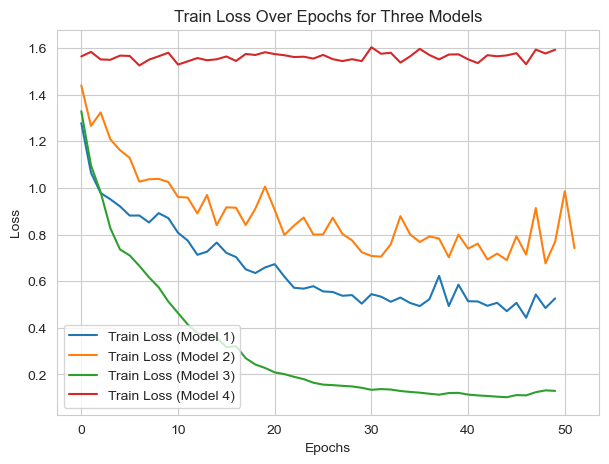

In [91]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['train loss'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['train loss'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['train_loss'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['train loss'], label='Train Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs for Three Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


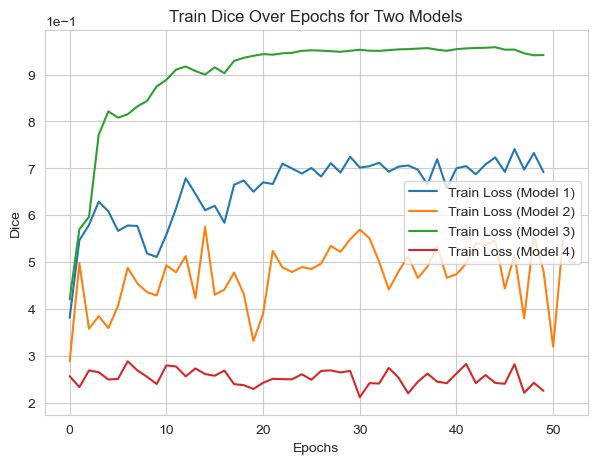

In [90]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['train_dice'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['train_dice'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['train_dice'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['train_dice'], label='Train Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Train Dice Over Epochs for Two Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


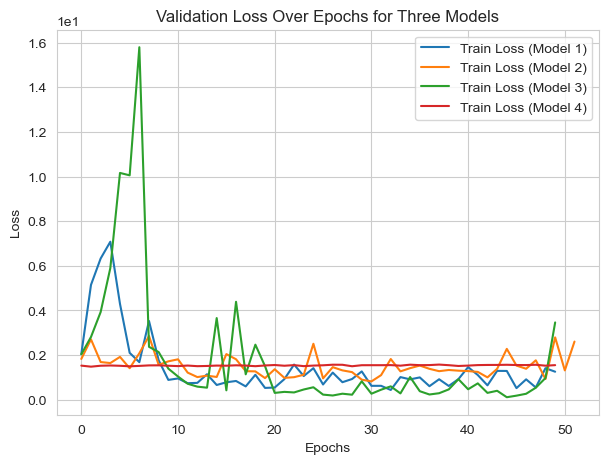

In [89]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['valid loss'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['valid loss'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['val_loss'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['valid loss'], label='Train Loss (Model 4)')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs for Three Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


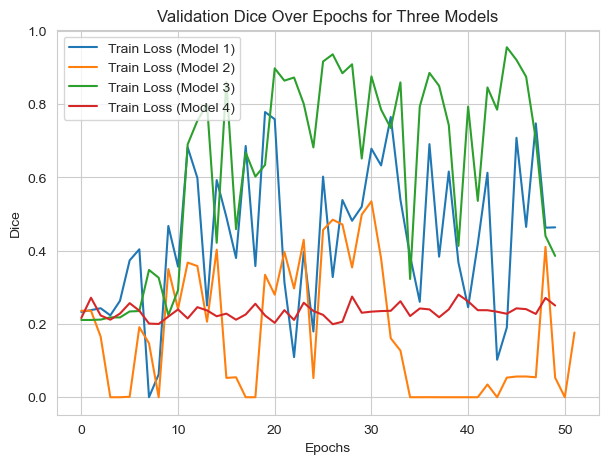

In [92]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['val_dice'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['val_dice'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['val_dice'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['val_dice'], label='Train Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Validation Dice Over Epochs for Three Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


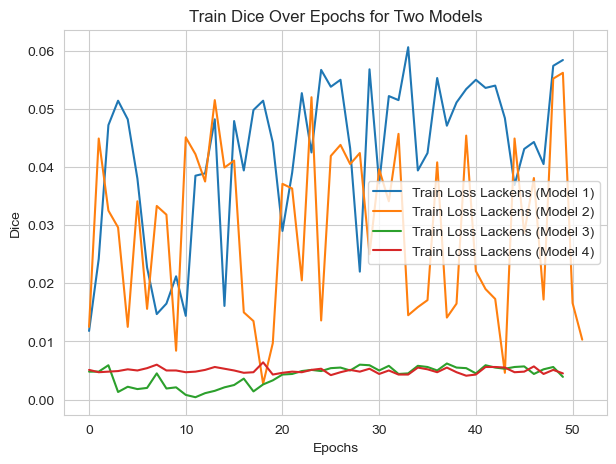

In [93]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['train_l_dice'], label='Train Loss Lackens (Model 1)')
plt.plot(m2.index, m2['train_l_dice'], label='Train Loss Lackens (Model 2)')
plt.plot(m3.index, m3['train_l_dice'], label='Train Loss Lackens (Model 3)')
plt.plot(m4.index, m4['train_l_dice'], label='Train Loss Lackens (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Train Dice Over Epochs for Two Models')
plt.legend()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


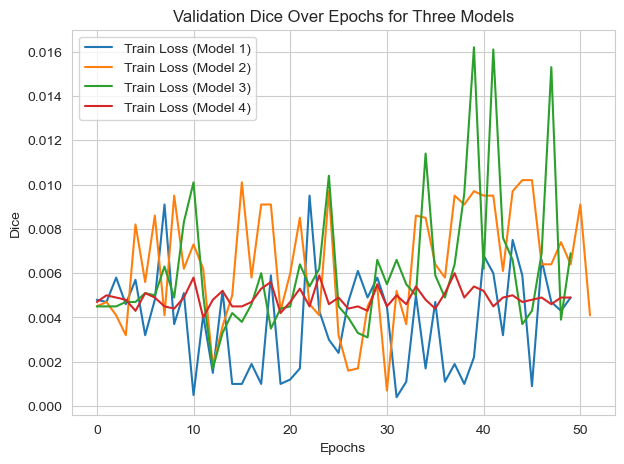

In [94]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['val_l_dice'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['val_l_dice'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['val_l_dice'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['val_l_dice'], label='Train Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Validation Dice Over Epochs for Three Models')
plt.legend()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


In [106]:
m1_file = 'model1.pt'
m2_file = 'model2.pt'
m3_file = 'model3_old.pt'
m4_file = 'model4.pt'

In [96]:
model1 = UNet(1, 1)
state_dict = torch.load(m1_file)  # Load the state_dict
model1.load_state_dict(state_dict)  # Load weights into the model
model1 = model1.to(device)
model1.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_92242/3524046012.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m1_file)  # Load the 

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [97]:
model2 = UNet(1, 1)
state_dict = torch.load(m2_file)  # Load the state_dict
model2.load_state_dict(state_dict)  # Load weights into the model
model2 = model2.to(device)
model2.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_92242/1254520505.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m2_file)  # Load the 

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [98]:
model3 = UNet(1, 1)
state_dict = torch.load(m3_file)  # Load the state_dict
model3.load_state_dict(state_dict)  # Load weights into the model
model3 = model3.to(device)
model3.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_92242/2572230083.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m3_file)  # Load the 

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [110]:
model4 = UNetFT(1,1)
state_dict = torch.load(m4_file)  # Load the state_dict
model4.load_state_dict(state_dict)  # Load weights into the model
model = model4.to(device)
model4.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_92242/1821071717.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/p

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [108]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ], )

test_batch_size = 4
test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)

testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=True, num_workers=1)
dict_file = './model_results1.txt'
model_file = './model1.pt'


Dice Coefficient: 0.8487908840179443
Dice Coefficient Lackens: 0.002943316474556923
IoU: 0.7432303428649902
IoU Lackens: 0.0017154966481029987
Accuracy: 0.9063389301300049
Accuracy Lackens: 0.4872400462627411


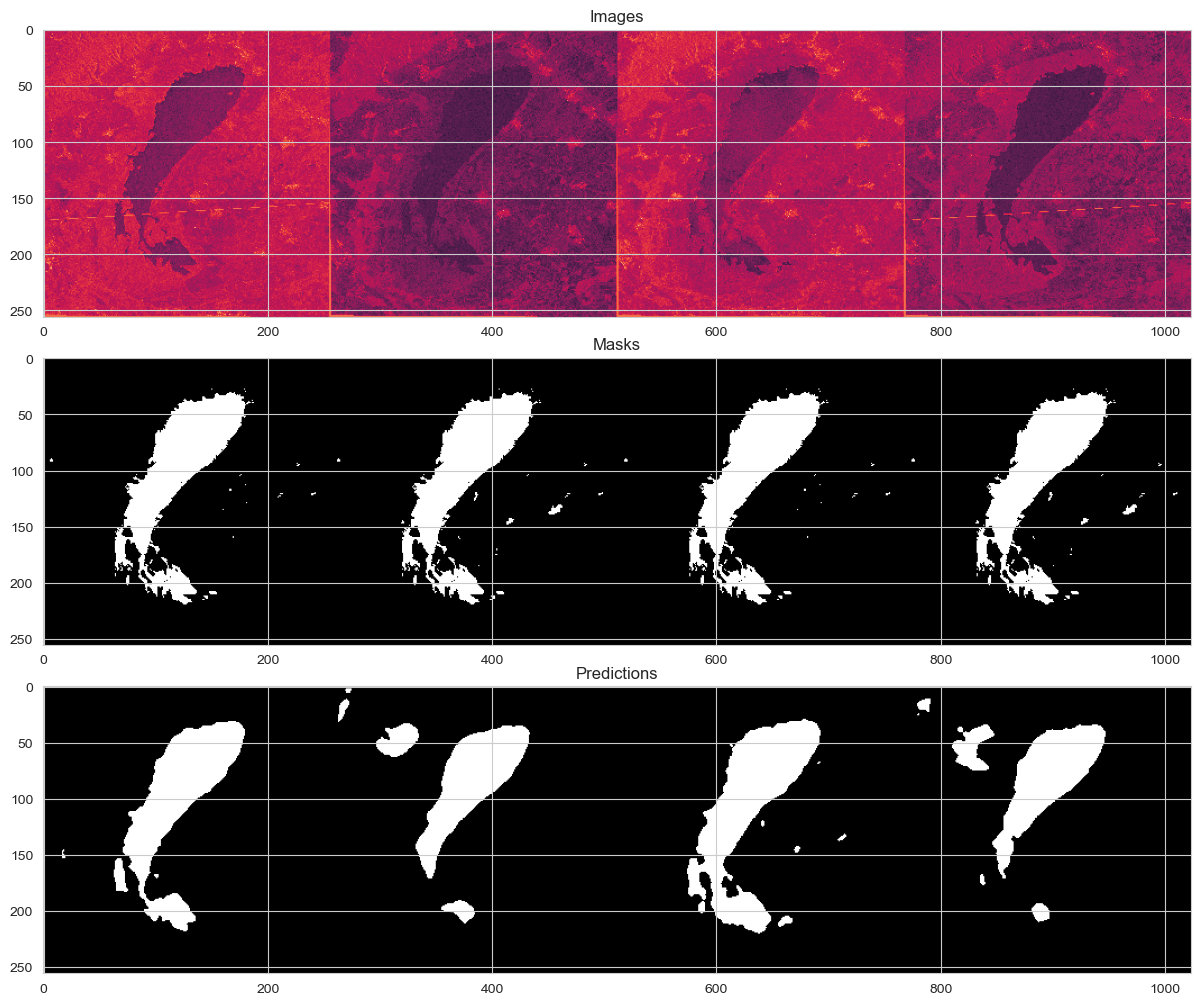

In [109]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model1(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.7601253986358643
Dice Coefficient Lackens: 0.00017679073789622635
IoU: 0.6139698028564453
IoU Lackens: 4.359197919256985e-05
Accuracy: 0.822941780090332
Accuracy Lackens: 0.4572625160217285


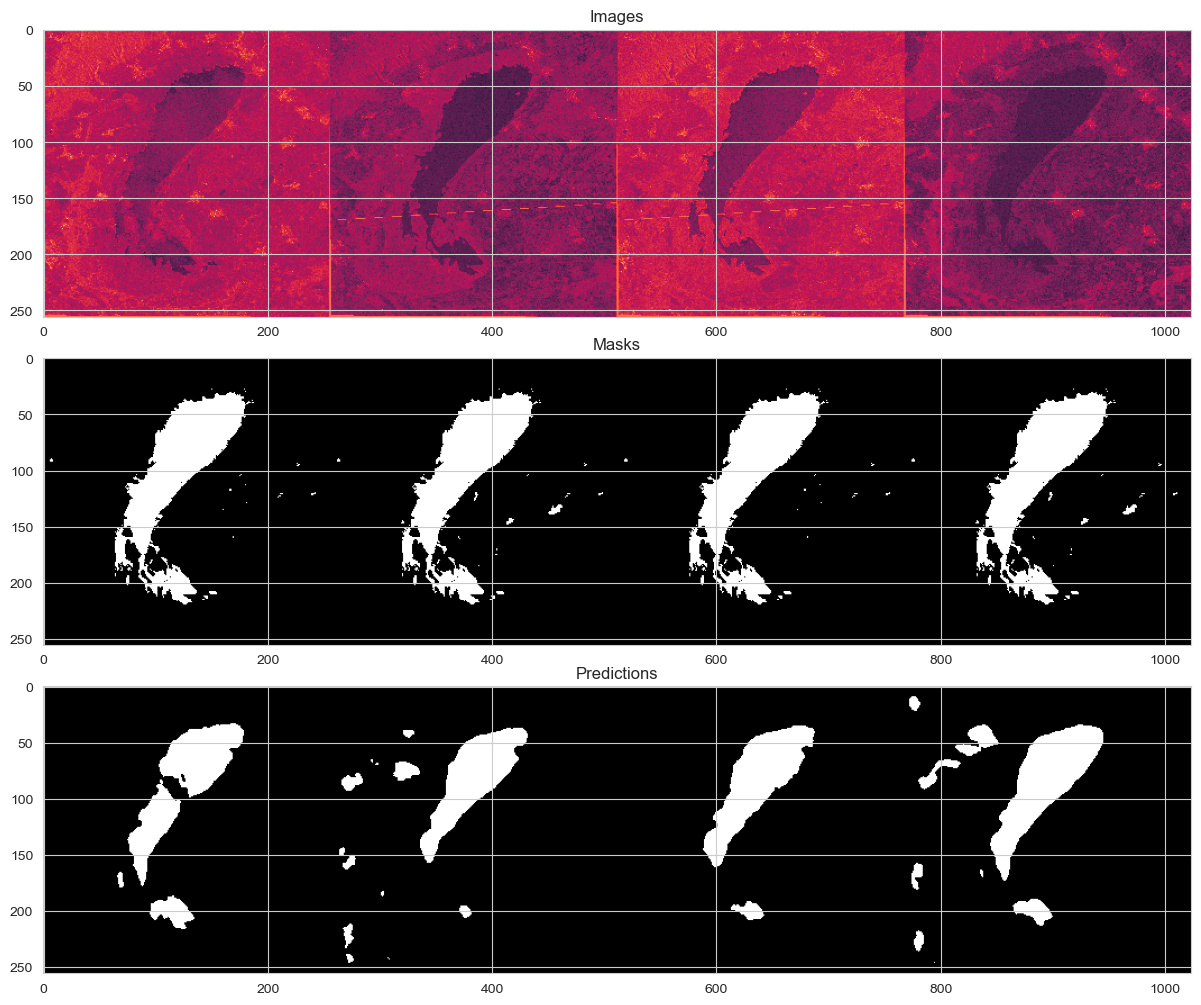

In [103]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model2(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.9496827125549316
Dice Coefficient Lackens: 0.004942998290061951
IoU: 0.9042775630950928
IoU Lackens: 0.0024650502018630505
Accuracy: 0.9591572284698486
Accuracy Lackens: 0.5063602328300476


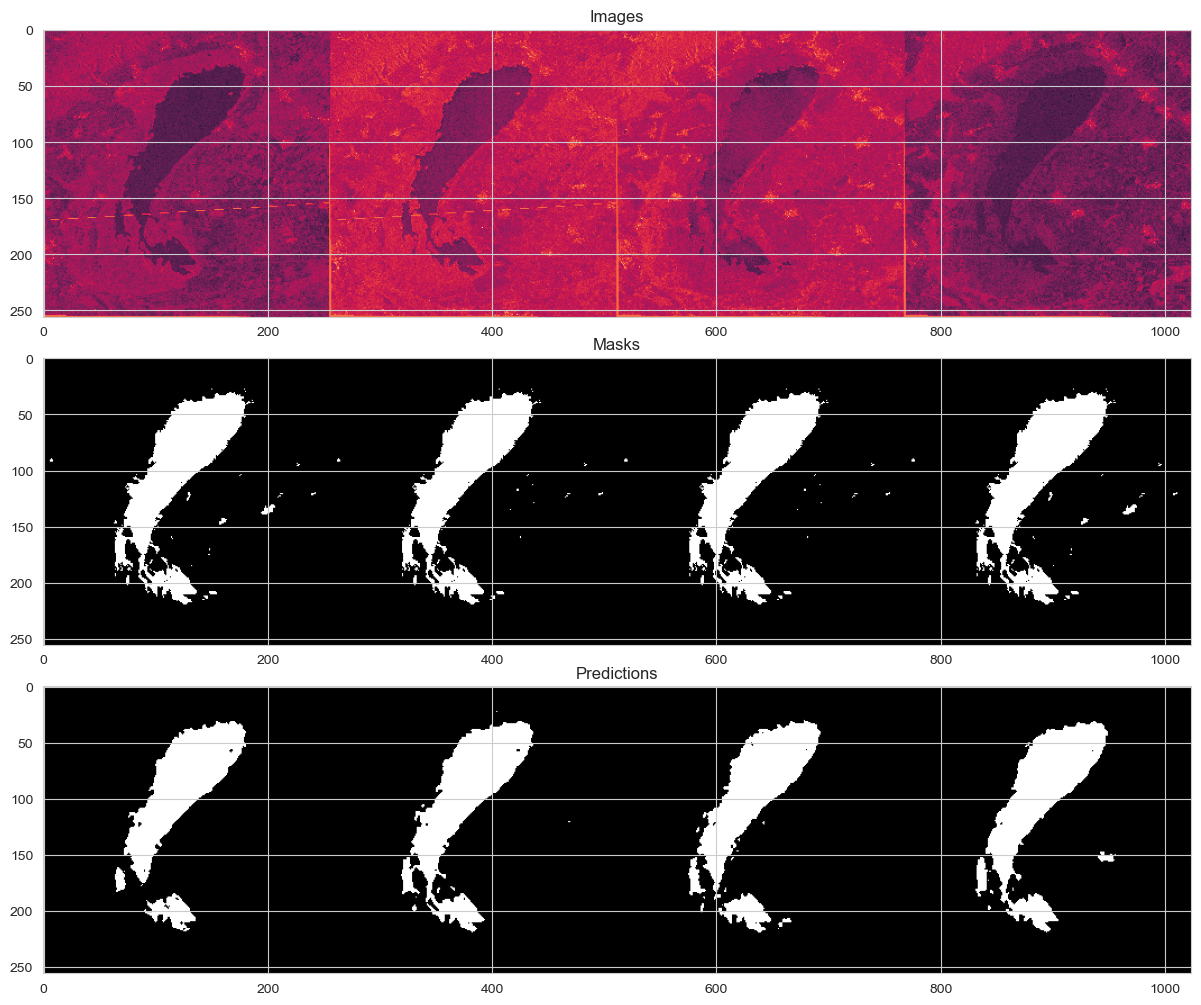

In [104]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model3(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.10204017162322998
Dice Coefficient Lackens: 0.004129492212086916
IoU: 0.055061761289834976
IoU Lackens: 0.002096214797347784
Accuracy: 0.44999179244041443
Accuracy Lackens: 0.49291345477104187


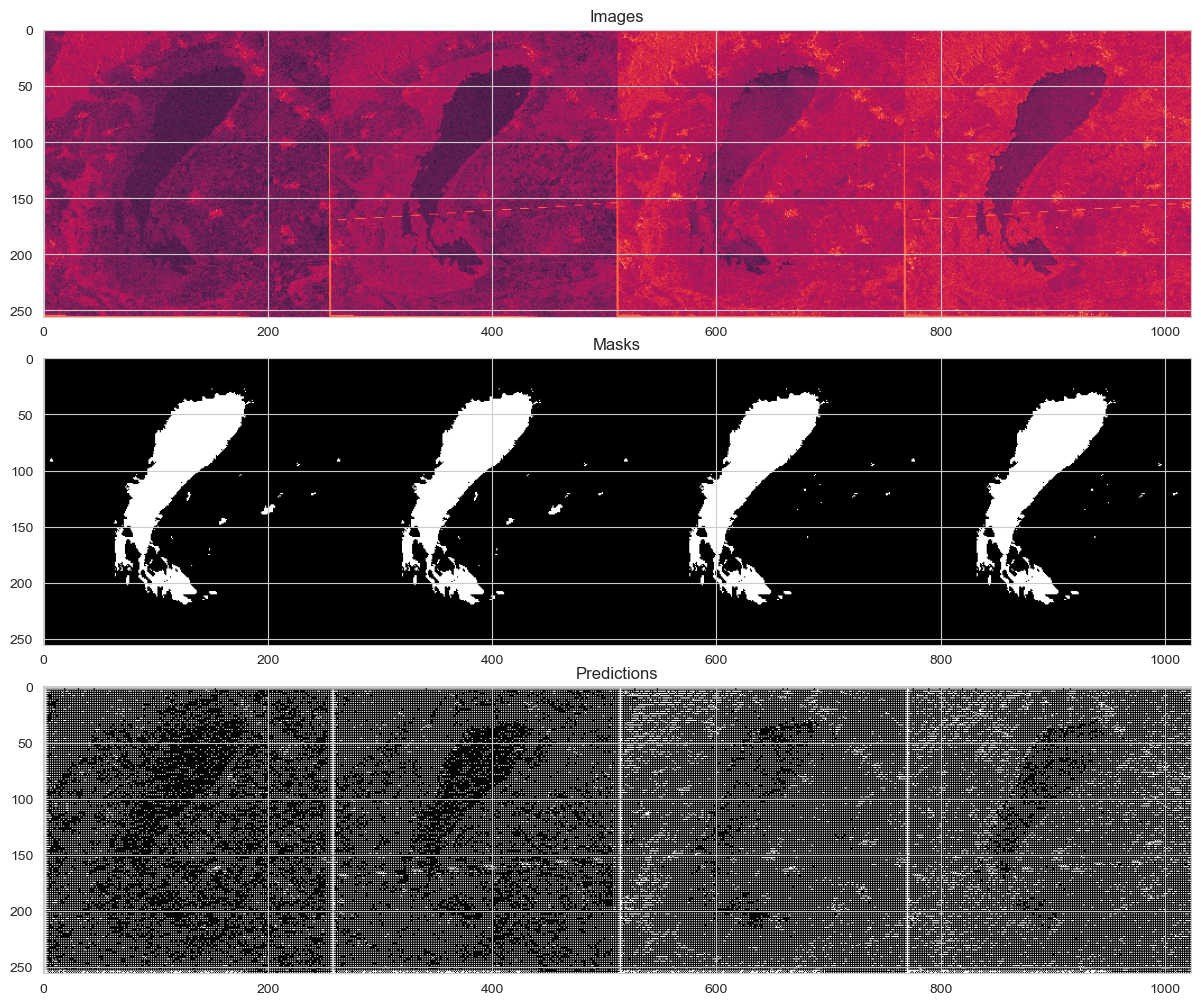

In [111]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model4(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)